This script trains and evaluates XGBoost models for forecasting day-ahead peak electricity demand.
Previously, we learned that model 4 using cbrt transformation without feature scaling was the optimal model 
based on performance and complexity. We will explore this combination further using model 4 as well as a few new models.

Note: This script contains only the code needed to reproduce the work (compare the models' overall performance and inform model selection).
The entire process involved examining detailed fold information, learning curves, and extensive model comparisons. 
For more comprehensive information, please refer to the "7C) Model Development (Cbrt Transformation of Target Variable, 
Without StandardScaler for Input Variables)" file in the full-code folder.



Data source:
- Preprocessed data: '6) daily_consumption_data_full.csv'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform
from sklearn.metrics import make_scorer, r2_score

df = pd.read_csv('6) daily_consumption_data_full.csv', parse_dates=['date'])

# Apply cube root transformation to 'consumption_peak_next_day'
df['cbrt_consumption_peak_next_day'] = np.cbrt(df['consumption_peak_next_day'])

In [2]:
# Categorisation of input variables
weather_features = [
    'temp_max_today', 'humidity_min_today', 'humidity_max_today', 'windspeed_max_today', 'precip_sum_today', 'solarradiation_sum_today',
    'humidity_at_peak_consumption_today', 'windspeed_at_peak_consumption_today', 'precip_at_peak_consumption_today', 
    'solarradiation_at_peak_consumption_today', 'temp_range_today', 'windspeed_min_today'
]

temporal_features = [
    'is_winter', 'is_summer', 'is_autumn', 'is_weekend', 'is_holiday', 'day_of_week_sin', 
    'day_of_week_cos', 'week_of_month_sin', 'week_of_month_cos'
]

consumption_features = [
    'consumption_sum_today', 'consumption_peak_today', 'consumption_min_today', 'prev_day_peak', 'same_day_last_week_peak', 
    'avg_peak_3d', 'avg_peak_7d', 'max_peak_7d', 'max_peak_3d'
]

household_features = [
    'household_size', 'male_occupants', 'female_occupants', 'count_children', 'ownership_owned', 
    'ownership_rented', 'ownership_other', 'work_from_home', 'housing_house', 'housing_apartment', 
    'count_rooms', 'electric_central_heating', 'heating_manual_boiler', 'heating_thermostatic_valves', 
    'heating_auto_set_times', 'heating_auto_temp_control', 'heating_not_sure', 'uses_electric_heater'
]

pricing_features = [
    'prop_low_price', 'prop_high_price', 'tariff_at_peak_consumption_today'
]

attitudinal_and_behavioural_features = [
    'interest_in_renewable_energy', 'interest_in_microgeneration', 'climate_change_concern', 
    'lifestyle_environment', 'smart_meter_bill_understanding', 'smart_meter_consumption_understanding'
]

appliance_features = [
    'washing_machine_fixed_schedule', 'tumble_dryer_fixed_schedule', 'dishwasher_fixed_schedule', 
    'immersion_water_heater_fixed_schedule', 'electric_oven_fixed_schedule', 'electric_hob_fixed_schedule', 
    'ironing_fixed_schedule', 'electric_shower_fixed_schedule', 'kettle_fixed_schedule', 'lighting_fixed_schedule', 
    'electric_heater_fixed_schedule', 'washer-dryer_combined_timer_use', 'washing_machine_timer_use', 
    'tumble_dryer_timer_use', 'dishwasher_timer_use', 'electric_space_heating_timer_use', 
    'washer-dryer_combined_ownership', 'washing_machine_ownership', 'tumble_dryer_ownership', 'dishwasher_ownership', 
    'electric_space_heating_ownership', 'count_low_efficiency_bulbs', 'total_refrigeration_units', 
    'count_cooking_appliances', 'count_laundry_appliances', 'count_kitchen_appliances', 
    'count_heating_water_appliances', 'count_entertainment_devices', 'count_computing_devices', 'count_tv', 
    'tv_energy_score'
]

In [3]:
# Define the improved parameter grid for Random Search based on previous results
param_grid = {
    'n_estimators': randint(800, 2000),         # Widened range around previous best (1270) to accommodate different model complexities
    'max_depth': randint(4, 12),                # Widened range around previous best (8) for varying feature sets
    'learning_rate': loguniform(0.01, 0.29),    # Same as before. Best was 0.018
    'subsample': uniform(0.5, 0.5),             # Same range as before, centered around previous best (0.739)
    'colsample_bytree': uniform(0.5, 0.5),      # Same range as before, centered around previous best (0.729)
    'min_child_weight': randint(1, 10),         # Same as previous (best was 5)- Accommodates varying model complexities
    'gamma': uniform(0, 0.3),                   # Lowered the upper bound based on previous best (0.057)
    'reg_alpha': loguniform(1e-3, 1),           # Changed to loguniform to explore lower values more thoroughly. Previous best was 0.452
    'reg_lambda': loguniform(1e-3, 1)           # Changed to loguniformto explore lower values more thoroughly. Previous best was 0.450
}

# Define date ranges for folds
folds = [
    ('2013-01-08', '2013-08-31', '2013-09-01', '2013-09-30'),
    ('2013-01-08', '2013-09-30', '2013-10-01', '2013-10-31'),
    ('2013-01-08', '2013-10-31', '2013-11-01', '2013-11-30')
]

# Custom functions to calculate error metrics (for cbrt transformation)
def custom_mae(y_true, y_pred):
    return np.mean(np.abs(y_true**3 - y_pred**3))

def custom_mape(y_true, y_pred):
    y_true_inv = y_true**3
    y_pred_inv = y_pred**3
    mask = y_true_inv != 0
    return np.mean(np.abs((y_true_inv[mask] - y_pred_inv[mask]) / y_true_inv[mask])) * 100

def custom_wape(y_true, y_pred):
    y_true_inv = y_true**3
    y_pred_inv = y_pred**3
    return np.sum(np.abs(y_true_inv - y_pred_inv)) / np.sum(np.abs(y_true_inv)) * 100

def custom_r2(y_true, y_pred):
    return r2_score(y_true**3, y_pred**3)

# Define WAPE scorer
wape_scorer = make_scorer(custom_wape, greater_is_better=False)

# Create a global create_dataset (needed for learning curve)
def create_dataset(df, start_date, end_date, features, target):
    mask = (df['date'] >= pd.to_datetime(start_date)) & (df['date'] <= pd.to_datetime(end_date))
    X = df.loc[mask, features]
    y = df.loc[mask, target]
    household_ids = df.loc[mask, 'household_id']
    dates = df.loc[mask, 'date']
    return X, y, household_ids, dates

In [4]:
# Function to plot the test results
def plot_test_results(model_name, predictions, actuals, household_ids, dates):
    # Convert predictions and actuals back to original scale
    predictions_original = predictions**3
    actuals_original = actuals**3

    # Create a DataFrame with the results
    results_df = pd.DataFrame({
        'household_id': household_ids,
        'date': dates,
        'actual': actuals_original,
        'predicted': predictions_original
    })

    # Scatter plot of Actual vs Predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(actuals_original, predictions_original, alpha=0.5)
    plt.plot([actuals_original.min(), actuals_original.max()], [actuals_original.min(), actuals_original.max()], 'r--')
    plt.xlabel('Actual Peak Consumption (kWh)')
    plt.ylabel('Predicted Peak Consumption (kWh)')
    plt.title(f'{model_name}: Actual vs Predicted Peak Consumption')
    plt.show()

    # Time series plot for a few random households
    np.random.seed(1)
    random_households = np.random.choice(results_df['household_id'].unique(), 3, replace=False)
    
    plt.figure(figsize=(15, 10))
    for i, household in enumerate(random_households, 1):
        household_data = results_df[results_df['household_id'] == household]
        plt.subplot(3, 1, i)
        plt.plot(household_data['date'], household_data['actual'], label='Actual')
        plt.plot(household_data['date'], household_data['predicted'], label='Predicted')
        plt.title(f'Household {household}')
        plt.xlabel('Date')
        plt.ylabel('Peak Consumption (kWh)')
        plt.legend()
    plt.tight_layout()
    plt.show()

    # Error distribution
    errors = actuals_original - predictions_original
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True)
    plt.xlabel('Prediction Error (kWh)')
    plt.ylabel('Frequency')
    plt.title(f'{model_name}: Distribution of Prediction Errors')
    plt.show()

    # Print summary statistics
    print(f"\nSummary Statistics for {model_name}:")
    print(f"Mean Error: {errors.mean():.4f}")
    print(f"Median Error: {np.median(errors):.4f}")
    print(f"Standard Deviation of Error: {errors.std():.4f}")
    print(f"5th Percentile of Error: {np.percentile(errors, 5):.4f}")
    print(f"95th Percentile of Error: {np.percentile(errors, 95):.4f}")
    print()
    print("___________________________________________________________")

In [5]:
# Main function to run the model
def run_model(features, target, df, folds, param_grid, model_name):
    # Initialise lists to store metrics
    mae_scores_train, mape_scores_train, wape_scores_train, r2_scores_train = [], [], [], []
    mae_scores_val, mape_scores_val, wape_scores_val, r2_scores_val = [], [], [], []
    feature_importances = []
    best_params_list = []

    print(f"\n--- Running {model_name} ---\n")

    for fold, (train_start, train_end, val_start, val_end) in enumerate(folds, 1):
        # Create training and validation sets 
        X_train, y_train, _, _ = create_dataset(df, train_start, train_end, features, target)
        X_val, y_val, _, _ = create_dataset(df, val_start, val_end, features, target)
        
        tscv = TimeSeriesSplit(n_splits=3)
        
        # Random Search CV
        model = XGBRegressor(objective='reg:squarederror', n_jobs=16, enable_categorical=True)
        random_search = RandomizedSearchCV(model, param_distributions=param_grid, 
                                           n_iter=200, cv=tscv.split(X_train), 
                                           scoring=wape_scorer,  
                                           n_jobs=-1, random_state=1)
        random_search.fit(X_train, y_train)
        
        # Get best model and parameters
        best_model = random_search.best_estimator_
        best_params = random_search.best_params_
        best_params_list.append(best_params)
        
        # Training Metrics
        train_predictions = best_model.predict(X_train)
        train_mae = custom_mae(y_train, train_predictions)
        train_mape = custom_mape(y_train, train_predictions)
        train_wape = custom_wape(y_train, train_predictions)
        train_r2 = custom_r2(y_train, train_predictions)
        mae_scores_train.append(train_mae)
        mape_scores_train.append(train_mape)
        wape_scores_train.append(train_wape)
        r2_scores_train.append(train_r2)
        
        # Validation Metrics
        val_predictions = best_model.predict(X_val)
        val_mae = custom_mae(y_val, val_predictions)
        val_mape = custom_mape(y_val, val_predictions)
        val_wape = custom_wape(y_val, val_predictions)
        val_r2 = custom_r2(y_val, val_predictions)
        mae_scores_val.append(val_mae)
        mape_scores_val.append(val_mape)
        wape_scores_val.append(val_wape)
        r2_scores_val.append(val_r2)
        
        # Feature importances
        importances = best_model.feature_importances_
        feature_importances.append(dict(zip(features, importances)))

    avg_train_mae = np.mean(mae_scores_train)
    avg_train_mape = np.mean(mape_scores_train)
    avg_train_wape = np.mean(wape_scores_train)
    avg_train_r2 = np.mean(r2_scores_train)
    avg_val_mae = np.mean(mae_scores_val)
    avg_val_mape = np.mean(mape_scores_val)
    avg_val_wape = np.mean(wape_scores_val)
    avg_val_r2 = np.mean(r2_scores_val)

    print(f"Average Training MAE: {avg_train_mae:.4f}")
    print(f"Average Training MAPE: {avg_train_mape:.4f}%")
    print(f"Average Training WAPE: {avg_train_wape:.4f}%")
    print(f"Average Training R²: {avg_train_r2:.4f}")
    print(f"Average Validation MAE: {avg_val_mae:.4f}")
    print(f"Average Validation MAPE: {avg_val_mape:.4f}%")
    print(f"Average Validation WAPE: {avg_val_wape:.4f}%")
    print(f"Average Validation R²: {avg_val_r2:.4f}")

    # Define test set dates
    test_start = '2013-12-01'
    test_end = '2013-12-30'

    # Create final training and test sets
    X_train_final, y_train_final, _, _ = create_dataset(df, df['date'].min(), pd.to_datetime(test_start) - pd.Timedelta(days=1), features, target)
    X_test, y_test, test_household_ids, test_dates = create_dataset(df, test_start, test_end, features, target)

    # Train final model
    final_params = best_params_list[np.argmin(wape_scores_val)]
    final_model = XGBRegressor(**final_params, enable_categorical=True)
    final_model.fit(X_train_final, y_train_final)

    # Make predictions and calculate test metrics
    test_predictions = final_model.predict(X_test)
    test_mae = custom_mae(y_test, test_predictions)
    test_mape = custom_mape(y_test, test_predictions)
    test_wape = custom_wape(y_test, test_predictions)
    test_r2 = custom_r2(y_test, test_predictions)
    print(f"\nMetrics on test set:")
    print(f"MAE: {test_mae:.4f}")
    print(f"MAPE: {test_mape:.4f}%")
    print(f"WAPE: {test_wape:.4f}%")
    print(f"R²: {test_r2:.4f}")

    # Plot feature importances
    final_importances = final_model.feature_importances_
    feature_imp = pd.DataFrame(sorted(zip(final_importances, features)), columns=['Value','Feature'])

    plt.figure(figsize=(10, min(20, len(features) * 0.3)))
    plt.barh(feature_imp['Feature'], feature_imp['Value'])
    plt.title(f'Feature Importances - {model_name}')
    plt.xlabel('Importance')

    for i, v in enumerate(feature_imp['Value']):
        plt.text(v, i, f' {v:.3f}', va='center')

    plt.tight_layout()
    plt.show()

    return final_model, test_mae, test_mape, test_wape, test_r2, dict(zip(features, final_importances)), avg_train_mae, avg_train_mape, avg_train_wape, avg_train_r2, avg_val_mae, avg_val_mape, avg_val_wape, avg_val_r2, test_predictions, y_test, test_household_ids, test_dates

# Create new aggregated features for Model 5-7

In [6]:
# Heating control sophistication score
def heating_control_score(row):
    scores = [0]
    if row['heating_manual_boiler']:
        scores.append(1)
    if row['heating_thermostatic_valves']:
        scores.append(2)
    if row['heating_auto_set_times']:
        scores.append(3)
    if row['heating_auto_temp_control']:
        scores.append(4)
    if row['heating_not_sure']:
        return 0
    return max(scores)

df['heating_control_score'] = df.apply(heating_control_score, axis=1)

# Total appliance count
appliance_count_cols = ['count_cooking_appliances', 'count_laundry_appliances', 
                        'count_kitchen_appliances', 'count_heating_water_appliances', 
                        'count_entertainment_devices', 'count_computing_devices', 
                        'count_tv']

ownership_cols = ['washer-dryer_combined_ownership', 'washing_machine_ownership', 
                  'tumble_dryer_ownership', 'dishwasher_ownership', 'electric_space_heating_ownership']

df['total_appliance_count'] = df[appliance_count_cols].sum(axis=1) + df[ownership_cols].sum(axis=1)

# Schedule rigidity
fixed_schedule_cols = [col for col in df.columns if col.endswith('_fixed_schedule')]
df['schedule_rigidity'] = df[fixed_schedule_cols].sum(axis=1)

# Timer use aggregation
timer_use_cols = [col for col in df.columns if col.endswith('_timer_use')]
df['timer_use_score'] = df[timer_use_cols].sum(axis=1)

# People per room/ Household density
df['people_per_room'] = df['household_size'] / df['count_rooms']

# Electric heating reliance
df['electric_heating_score'] = df['electric_central_heating'].astype(int) + df['uses_electric_heater'].astype(int)

newly_aggregated_features = [
    'heating_control_score', 'total_appliance_count',
    'schedule_rigidity', 'timer_use_score', 'people_per_room', 'electric_heating_score'
]

# Convert aggregated features to numeric types
df['heating_control_score'] = pd.to_numeric(df['heating_control_score'], errors='coerce')
df['total_appliance_count'] = pd.to_numeric(df['total_appliance_count'], errors='coerce')
df['schedule_rigidity'] = pd.to_numeric(df['schedule_rigidity'], errors='coerce')
df['timer_use_score'] = pd.to_numeric(df['timer_use_score'], errors='coerce')
df['people_per_room'] = pd.to_numeric(df['people_per_room'], errors='coerce')
df['electric_heating_score'] = pd.to_numeric(df['electric_heating_score'], errors='coerce')

columns_used_for_aggregation = [
    'heating_manual_boiler', 'heating_thermostatic_valves', 
    'heating_auto_set_times', 'heating_auto_temp_control', 'heating_not_sure',
    'count_cooking_appliances', 'count_laundry_appliances', 'count_kitchen_appliances', 
    'count_heating_water_appliances', 'count_entertainment_devices', 'count_computing_devices',
    'count_tv', 'count_fridges_and_freezers', 'count_energy_saving_devices', 
    'washer-dryer_combined_ownership', 'washing_machine_ownership', 'tumble_dryer_ownership',
    'dishwasher_ownership', 'electric_space_heating_ownership', 'household_size', 
    'count_rooms', 'electric_central_heating', 'uses_electric_heater'
] + fixed_schedule_cols + timer_use_cols

# Define feature sets and train each model


--- Running Model 3 ---

Average Training MAE: 0.2966
Average Training MAPE: 36.9371%
Average Training WAPE: 26.6562%
Average Training R²: 0.7405
Average Validation MAE: 0.3389
Average Validation MAPE: 44.0733%
Average Validation WAPE: 30.2219%
Average Validation R²: 0.6170

Metrics on test set:
MAE: 0.3749
MAPE: 48.5312%
WAPE: 29.2680%
R²: 0.6546


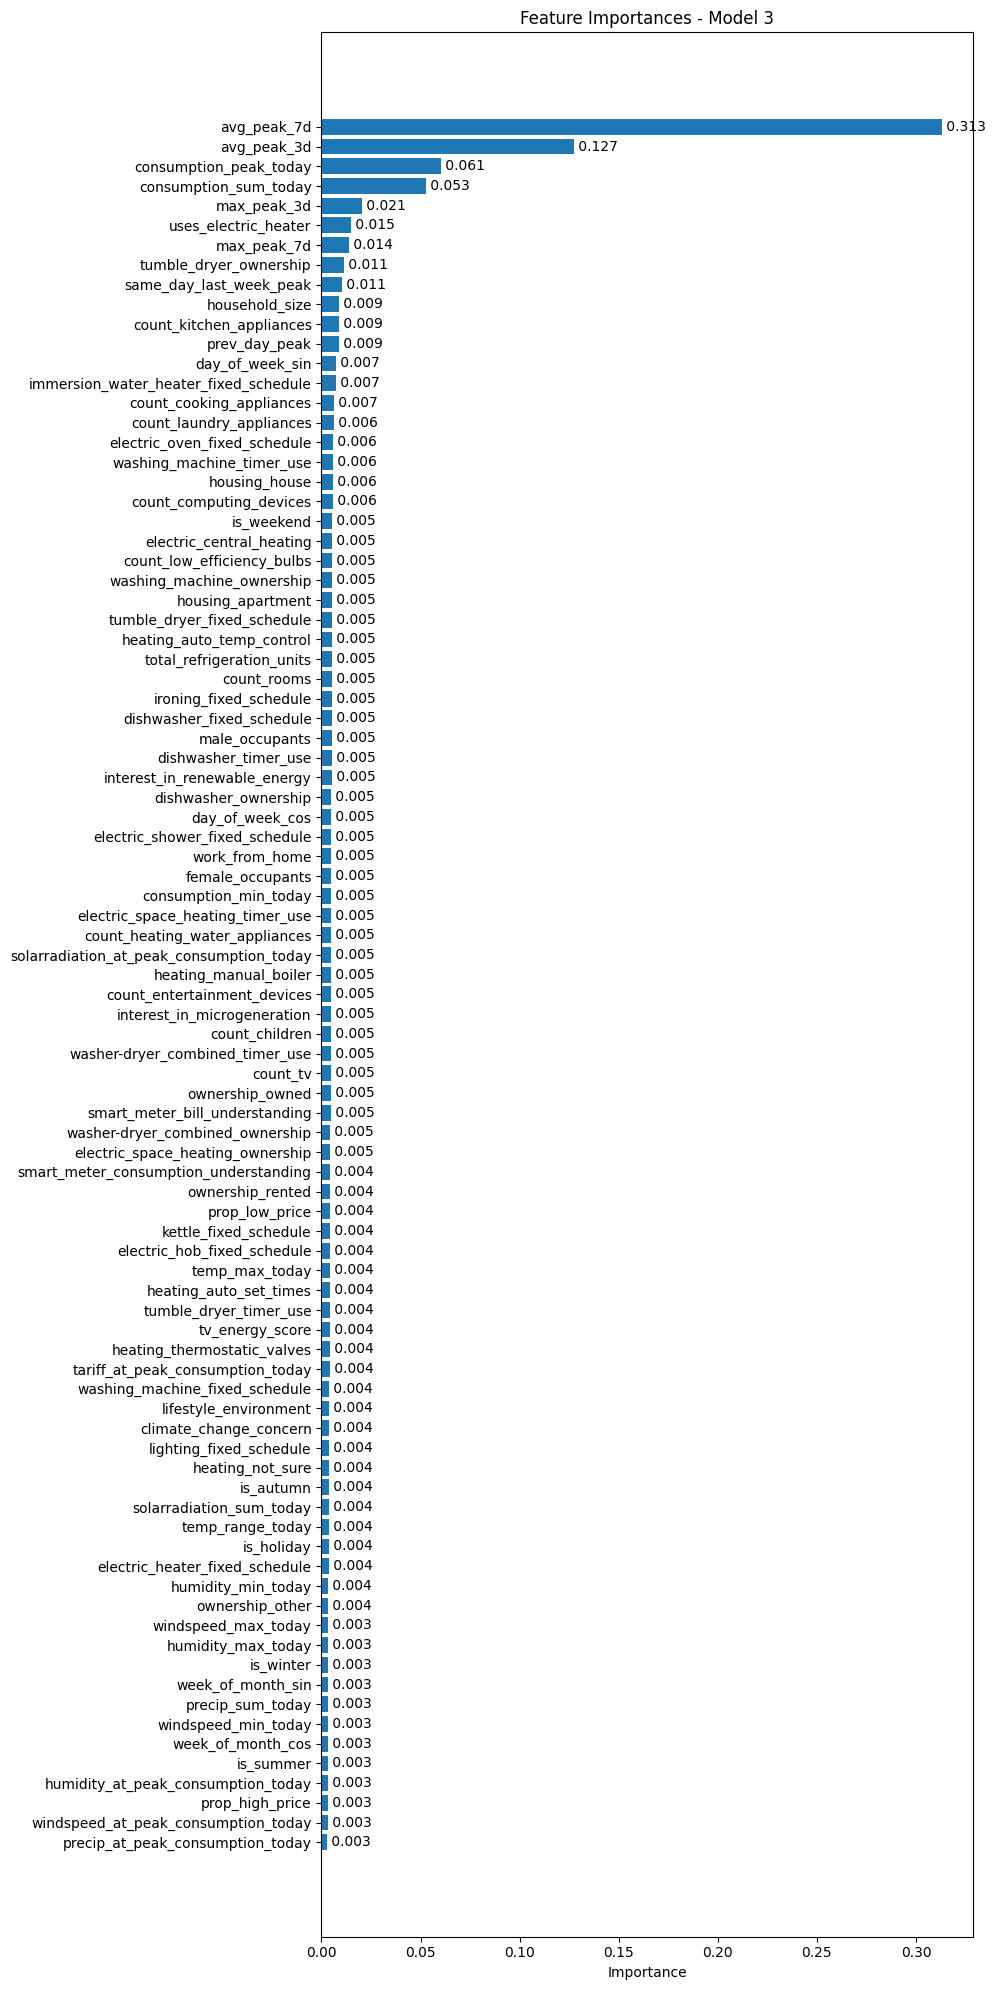


--- Running Model 4 (Only Top 15 Features from Model 3) ---

Average Training MAE: 0.3133
Average Training MAPE: 39.1597%
Average Training WAPE: 28.1623%
Average Training R²: 0.7085
Average Validation MAE: 0.3477
Average Validation MAPE: 44.3078%
Average Validation WAPE: 31.0137%
Average Validation R²: 0.5938

Metrics on test set:
MAE: 0.3798
MAPE: 47.0304%
WAPE: 29.6546%
R²: 0.6419


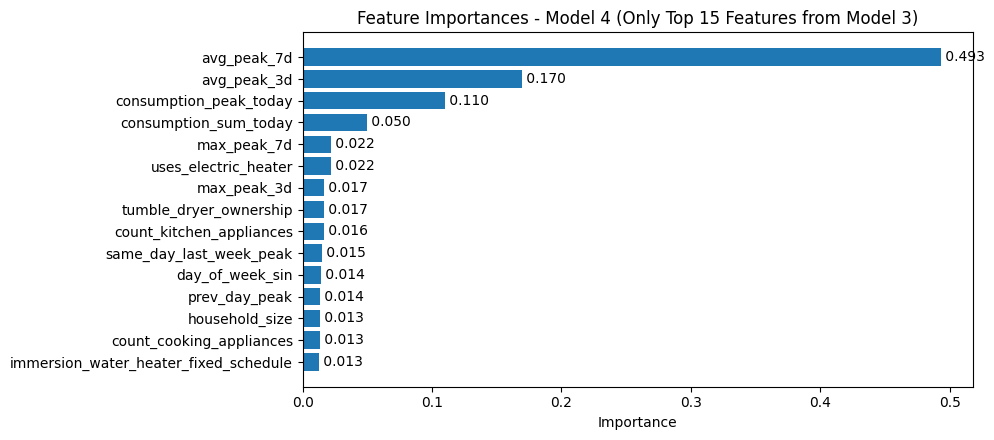


--- Running Model 5 (Model 3 with Aggregated Household Features) ---

Average Training MAE: 0.2853
Average Training MAPE: 35.2356%
Average Training WAPE: 25.6471%
Average Training R²: 0.7577
Average Validation MAE: 0.3380
Average Validation MAPE: 43.7429%
Average Validation WAPE: 30.1461%
Average Validation R²: 0.6184

Metrics on test set:
MAE: 0.3742
MAPE: 48.2494%
WAPE: 29.2139%
R²: 0.6553


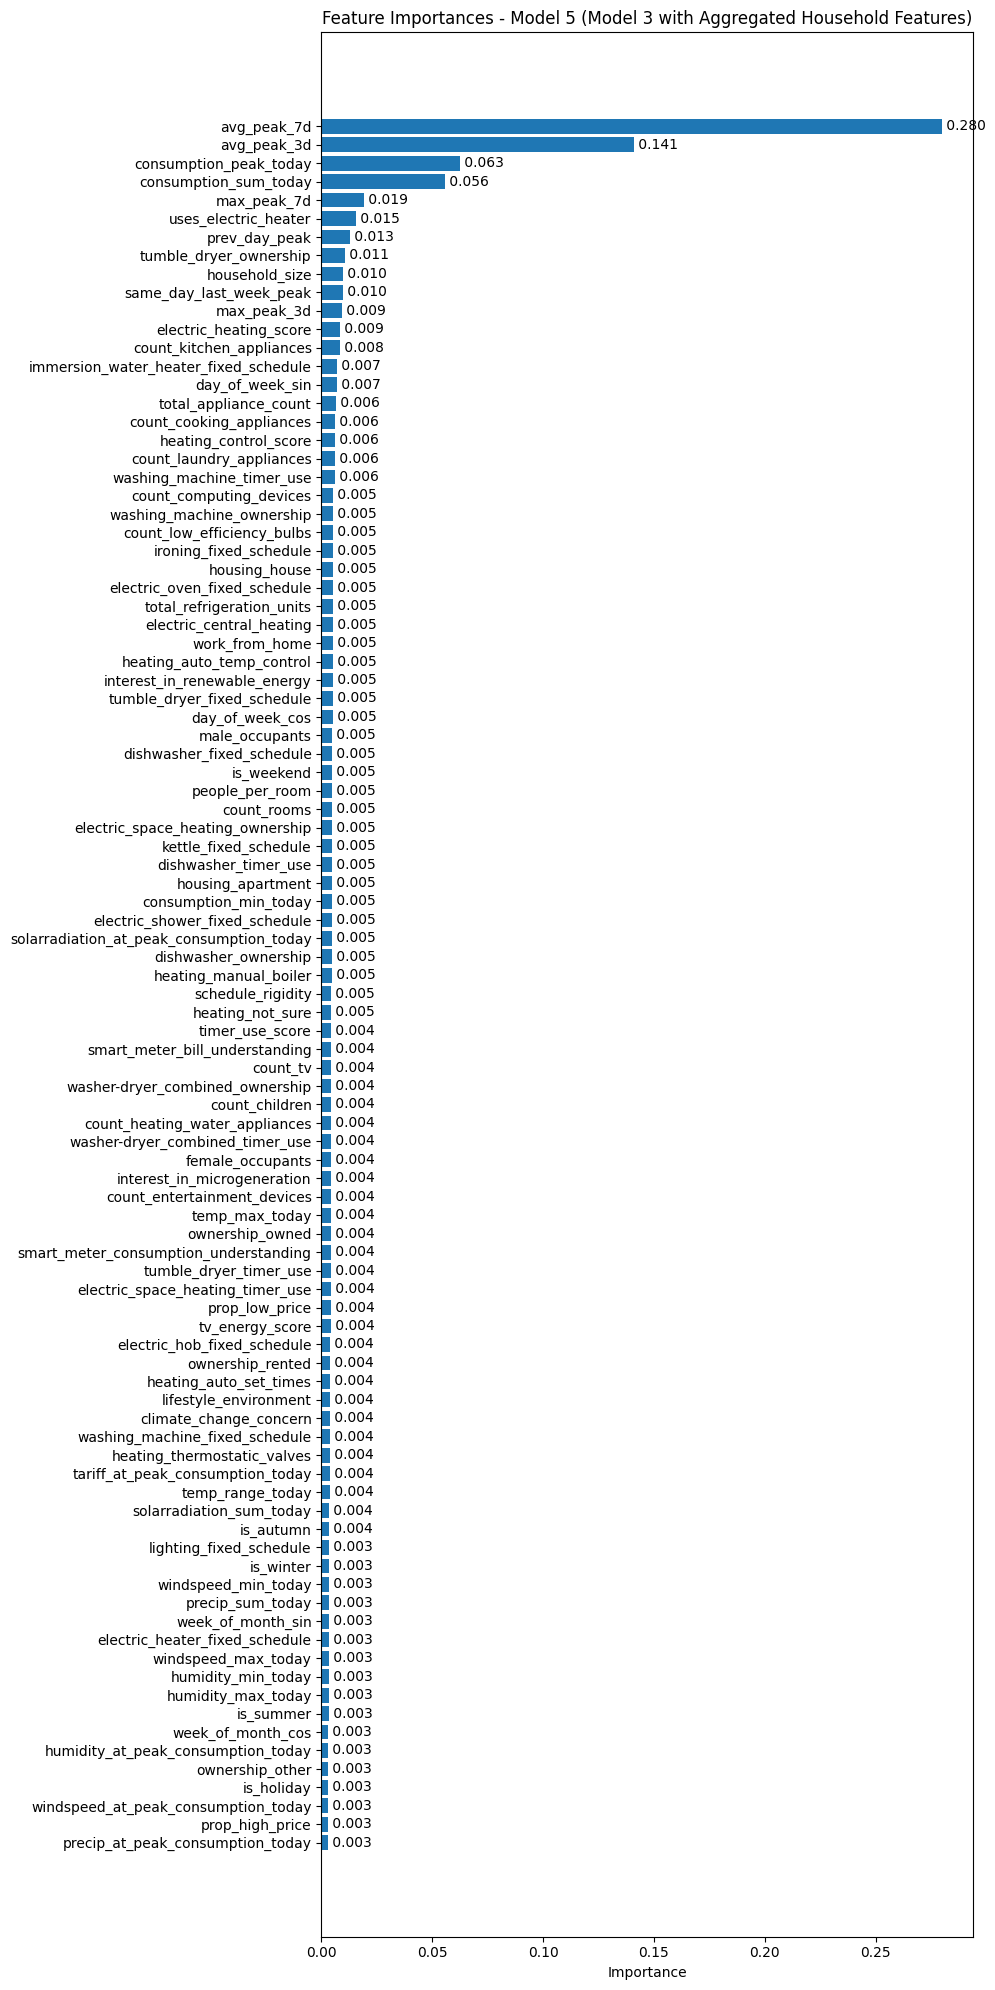


--- Running Model 6 (Model 3 with Aggregated Household Features Excluding Individual Features) ---

Average Training MAE: 0.3003
Average Training MAPE: 37.3670%
Average Training WAPE: 26.9914%
Average Training R²: 0.7340
Average Validation MAE: 0.3413
Average Validation MAPE: 44.2972%
Average Validation WAPE: 30.4407%
Average Validation R²: 0.6120

Metrics on test set:
MAE: 0.3770
MAPE: 48.7748%
WAPE: 29.4360%
R²: 0.6516


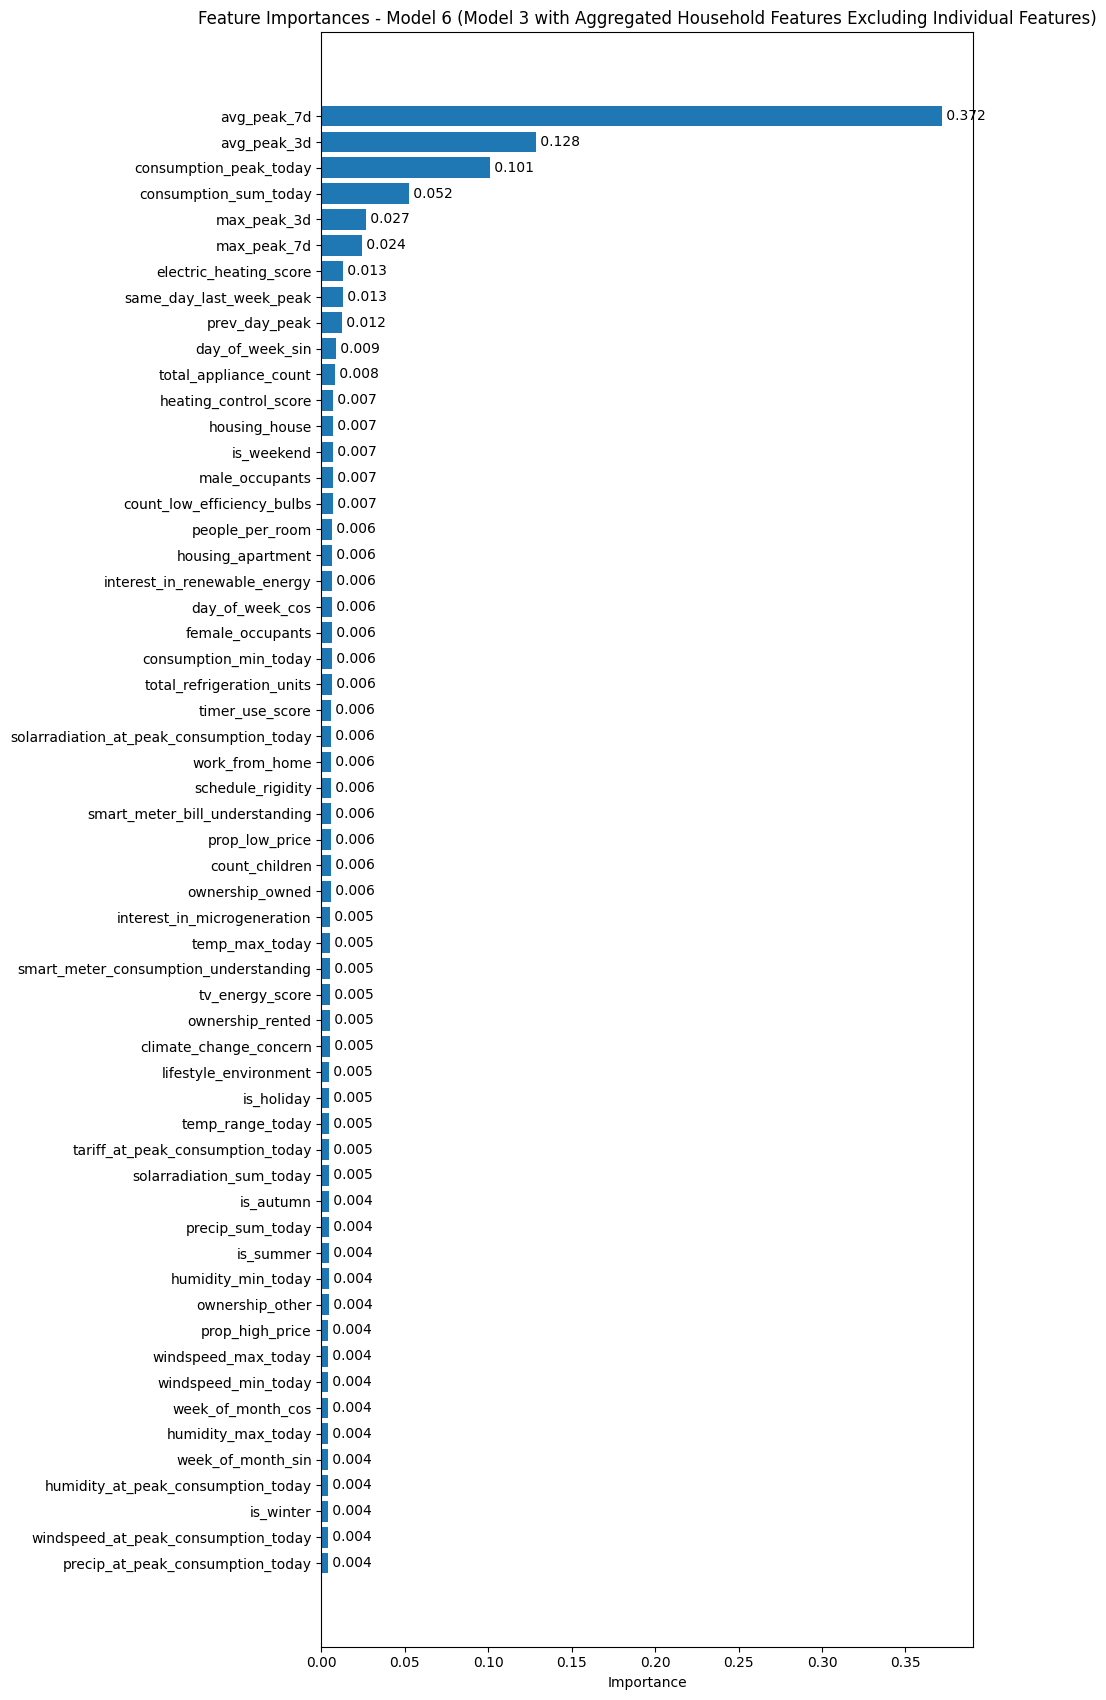


--- Running Model 7 (Only Top 15 Features from Model 6) ---

Average Training MAE: 0.3095
Average Training MAPE: 38.4590%
Average Training WAPE: 27.8169%
Average Training R²: 0.7158
Average Validation MAE: 0.3466
Average Validation MAPE: 44.0708%
Average Validation WAPE: 30.9163%
Average Validation R²: 0.5966

Metrics on test set:
MAE: 0.3795
MAPE: 46.3191%
WAPE: 29.6288%
R²: 0.6438


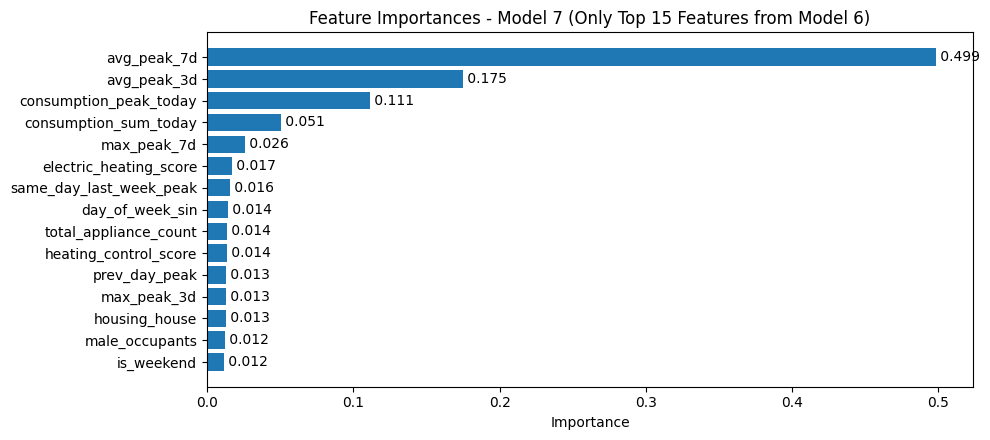

In [7]:
# Define feature sets
model_3_features = temporal_features + consumption_features + weather_features + household_features + pricing_features + attitudinal_and_behavioural_features + appliance_features

# Run model 3 to get importances for model 4
model_3, mae_3, mape_3, wape_3, r2_3, importances_3, avg_train_mae_3, avg_train_mape_3, avg_train_wape_3, avg_train_r2_3, avg_val_mae_3, avg_val_mape_3, avg_val_wape_3, avg_val_r2_3, test_predictions_3, y_test_3, test_household_ids_3, test_dates_3 = run_model(model_3_features, 'cbrt_consumption_peak_next_day', df, folds, param_grid, "Model 3")

# Train model 4, which only uses the top 15 features from model 3
model_4_features = [feature for feature, importance in sorted(importances_3.items(), key=lambda x: x[1], reverse=True)[:15]]
model_4, mae_4, mape_4, wape_4, r2_4, importances_4, avg_train_mae_4, avg_train_mape_4, avg_train_wape_4, avg_train_r2_4, avg_val_mae_4, avg_val_mape_4, avg_val_wape_4, avg_val_r2_4, test_predictions_4, y_test_4, test_household_ids_4, test_dates_4 = run_model(model_4_features, 'cbrt_consumption_peak_next_day', df, folds, param_grid, "Model 4 (Only Top 15 Features from Model 3)")

# Model 5: Use all the features from model 3 + aggregated features
model_5_features = model_3_features + newly_aggregated_features
model_5, mae_5, mape_5, wape_5, r2_5, importances_5, avg_train_mae_5, avg_train_mape_5, avg_train_wape_5, avg_train_r2_5, avg_val_mae_5, avg_val_mape_5, avg_val_wape_5, avg_val_r2_5, test_predictions_5, y_test_5, test_household_ids_5, test_dates_5 = run_model(model_5_features, 'cbrt_consumption_peak_next_day', df, folds, param_grid, "Model 5 (Model 3 with Aggregated Household Features)")

# Model 6: Same as Model 5 but without the individual features
model_6_features = [feature for feature in model_5_features if feature not in columns_used_for_aggregation]
model_6, mae_6, mape_6, wape_6, r2_6, importances_6, avg_train_mae_6, avg_train_mape_6, avg_train_wape_6, avg_train_r2_6, avg_val_mae_6, avg_val_mape_6, avg_val_wape_6, avg_val_r2_6, test_predictions_6, y_test_6, test_household_ids_6, test_dates_6 = run_model(model_6_features, 'cbrt_consumption_peak_next_day', df, folds, param_grid, "Model 6 (Model 3 with Aggregated Household Features Excluding Individual Features)")

# Model 7: Use only the top 15 features from importances_6
model_7_features = [feature for feature, importance in sorted(importances_6.items(), key=lambda item: item[1], reverse=True)[:15]]
model_7, mae_7, mape_7, wape_7, r2_7, importances_7, avg_train_mae_7, avg_train_mape_7, avg_train_wape_7, avg_train_r2_7, avg_val_mae_7, avg_val_mape_7, avg_val_wape_7, avg_val_r2_7, test_predictions_7, y_test_7, test_household_ids_7, test_dates_7 = run_model(model_7_features, 'cbrt_consumption_peak_next_day', df, folds, param_grid, "Model 7 (Only Top 15 Features from Model 6)")

# Compare the Models

In [11]:
models = [
    ("Model 3", mae_3, mape_3, wape_3, r2_3, model_3_features, avg_train_mae_3, avg_train_mape_3, avg_train_wape_3, avg_train_r2_3, avg_val_mae_3, avg_val_mape_3, avg_val_wape_3, avg_val_r2_3),
    ("Model 4", mae_4, mape_4, wape_4, r2_4, model_4_features, avg_train_mae_4, avg_train_mape_4, avg_train_wape_4, avg_train_r2_4, avg_val_mae_4, avg_val_mape_4, avg_val_wape_4, avg_val_r2_4),
    ("Model 5", mae_5, mape_5, wape_5, r2_5, model_5_features, avg_train_mae_5, avg_train_mape_5, avg_train_wape_5, avg_train_r2_5, avg_val_mae_5, avg_val_mape_5, avg_val_wape_5, avg_val_r2_5),
    ("Model 6", mae_6, mape_6, wape_6, r2_6, model_6_features, avg_train_mae_6, avg_train_mape_6, avg_train_wape_6, avg_train_r2_6, avg_val_mae_6, avg_val_mape_6, avg_val_wape_6, avg_val_r2_6),
    ("Model 7", mae_7, mape_7, wape_7, r2_7, model_7_features, avg_train_mae_7, avg_train_mape_7, avg_train_wape_7, avg_train_r2_7, avg_val_mae_7, avg_val_mape_7, avg_val_wape_7, avg_val_r2_7)
]


--- Final Model Comparison ---
Model 3:
  Avg Train MAE: 0.2966
  Avg Train MAPE: 36.9371%
  Avg Train WAPE: 26.6562%
  Avg Train R²: 0.7405
  Avg Validation MAE: 0.3389
  Avg Validation MAPE: 44.0733%
  Avg Validation WAPE: 30.2219%
  Avg Validation R²: 0.6170
  Test MAE: 0.3749
  Test MAPE: 48.5312%
  Test WAPE: 29.2680%
  Test R²: 0.6546
  Number of features: 88

Model 4:
  Avg Train MAE: 0.3133
  Avg Train MAPE: 39.1597%
  Avg Train WAPE: 28.1623%
  Avg Train R²: 0.7085
  Avg Validation MAE: 0.3477
  Avg Validation MAPE: 44.3078%
  Avg Validation WAPE: 31.0137%
  Avg Validation R²: 0.5938
  Test MAE: 0.3798
  Test MAPE: 47.0304%
  Test WAPE: 29.6546%
  Test R²: 0.6419
  Number of features: 15

Model 5:
  Avg Train MAE: 0.2853
  Avg Train MAPE: 35.2356%
  Avg Train WAPE: 25.6471%
  Avg Train R²: 0.7577
  Avg Validation MAE: 0.3380
  Avg Validation MAPE: 43.7429%
  Avg Validation WAPE: 30.1461%
  Avg Validation R²: 0.6184
  Test MAE: 0.3742
  Test MAPE: 48.2494%
  Test WAPE: 29.2139

In [12]:
print("\n--- Final Model Comparison ---")
for model_name, mae, mape, wape, r2, features, avg_train_mae, avg_train_mape, avg_train_wape, avg_train_r2, avg_val_mae, avg_val_mape, avg_val_wape, avg_val_r2 in models:
    print(f"{model_name}:")
    print(f"  Avg Train MAE: {avg_train_mae:.4f}")
    print(f"  Avg Train MAPE: {avg_train_mape:.4f}%")
    print(f"  Avg Train WAPE: {avg_train_wape:.4f}%")
    print(f"  Avg Train R²: {avg_train_r2:.4f}")
    print(f"  Avg Validation MAE: {avg_val_mae:.4f}")
    print(f"  Avg Validation MAPE: {avg_val_mape:.4f}%")
    print(f"  Avg Validation WAPE: {avg_val_wape:.4f}%")
    print(f"  Avg Validation R²: {avg_val_r2:.4f}")
    print(f"  Test MAE: {mae:.4f}")
    print(f"  Test MAPE: {mape:.4f}%")
    print(f"  Test WAPE: {wape:.4f}%")
    print(f"  Test R²: {r2:.4f}")
    print(f"  Number of features: {len(features)}")
    print()


--- Final Model Comparison ---
Model 3:
  Avg Train MAE: 0.2966
  Avg Train MAPE: 36.9371%
  Avg Train WAPE: 26.6562%
  Avg Train R²: 0.7405
  Avg Validation MAE: 0.3389
  Avg Validation MAPE: 44.0733%
  Avg Validation WAPE: 30.2219%
  Avg Validation R²: 0.6170
  Test MAE: 0.3749
  Test MAPE: 48.5312%
  Test WAPE: 29.2680%
  Test R²: 0.6546
  Number of features: 88

Model 4:
  Avg Train MAE: 0.3133
  Avg Train MAPE: 39.1597%
  Avg Train WAPE: 28.1623%
  Avg Train R²: 0.7085
  Avg Validation MAE: 0.3477
  Avg Validation MAPE: 44.3078%
  Avg Validation WAPE: 31.0137%
  Avg Validation R²: 0.5938
  Test MAE: 0.3798
  Test MAPE: 47.0304%
  Test WAPE: 29.6546%
  Test R²: 0.6419
  Number of features: 15

Model 5:
  Avg Train MAE: 0.2853
  Avg Train MAPE: 35.2356%
  Avg Train WAPE: 25.6471%
  Avg Train R²: 0.7577
  Avg Validation MAE: 0.3380
  Avg Validation MAPE: 43.7429%
  Avg Validation WAPE: 30.1461%
  Avg Validation R²: 0.6184
  Test MAE: 0.3742
  Test MAPE: 48.2494%
  Test WAPE: 29.2139

# Model 7 was chosen as the optimal model due to its balance between performance and complexity

In [9]:
def plot_learning_curve(model, df, features, target, folds, model_name):
    train_scores, valid_scores = [], []

    for fold, (train_start, train_end, val_start, val_end) in enumerate(folds, 1):
        X_train, y_train, _, _ = create_dataset(df, train_start, train_end, features, target)
        X_val, y_val, _, _ = create_dataset(df, val_start, val_end, features, target)

        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)

        train_scores.append(custom_wape(y_train, train_pred))
        valid_scores.append(custom_wape(y_val, val_pred))

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(folds) + 1), train_scores, label='Training WAPE', marker='o')
    plt.plot(range(1, len(folds) + 1), valid_scores, label='Validation WAPE', marker='o')
    plt.xlabel('Fold')
    plt.ylabel('WAPE')
    plt.title(f'Learning Curve - {model_name}')
    plt.legend()
    plt.xticks(range(1, len(folds) + 1))
    plt.show()

    print(f"Training WAPE scores: {train_scores}")
    print(f"Validation WAPE scores: {valid_scores}")

In [14]:
# Print best hyperparameters for Model 7
print("\nBest hyperparameters used for Model 7:")
tuned_hyperparameters = ['n_estimators', 'max_depth', 'learning_rate', 'subsample', 'colsample_bytree', 'min_child_weight', 'gamma', 'reg_alpha', 'reg_lambda']
for param, value in model_7.get_params().items():
    if param in tuned_hyperparameters:
        print(f"{param}: {value}")


Best hyperparameters used for Model 7:
colsample_bytree: 0.8241563780815623
gamma: 0.05098221426517733
learning_rate: 0.016540578683031364
max_depth: 11
min_child_weight: 5
n_estimators: 1449
reg_alpha: 0.8845998752143264
reg_lambda: 0.6724110524452301
subsample: 0.669615333889757



Best hyperparameters used for Model 7:
colsample_bytree: 0.8241563780815623
gamma: 0.05098221426517733
learning_rate: 0.016540578683031364
max_depth: 11
min_child_weight: 5
n_estimators: 1449
reg_alpha: 0.8845998752143264
reg_lambda: 0.6724110524452301
subsample: 0.669615333889757


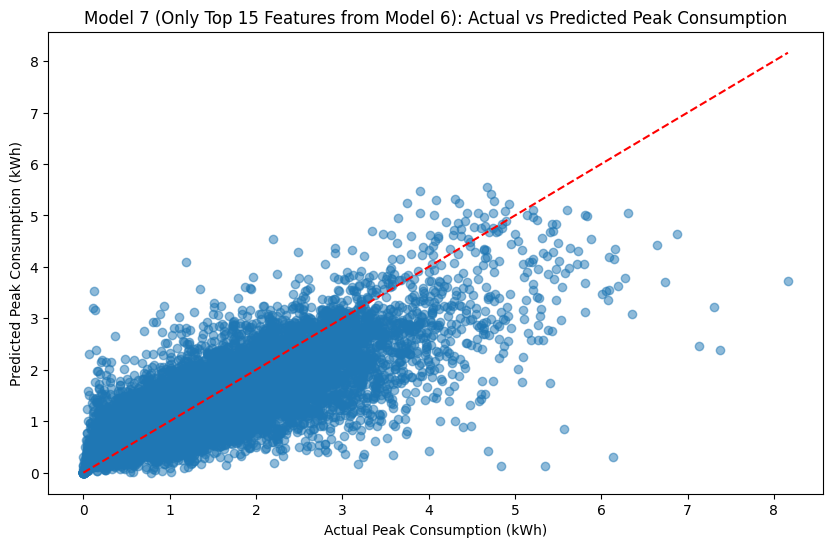

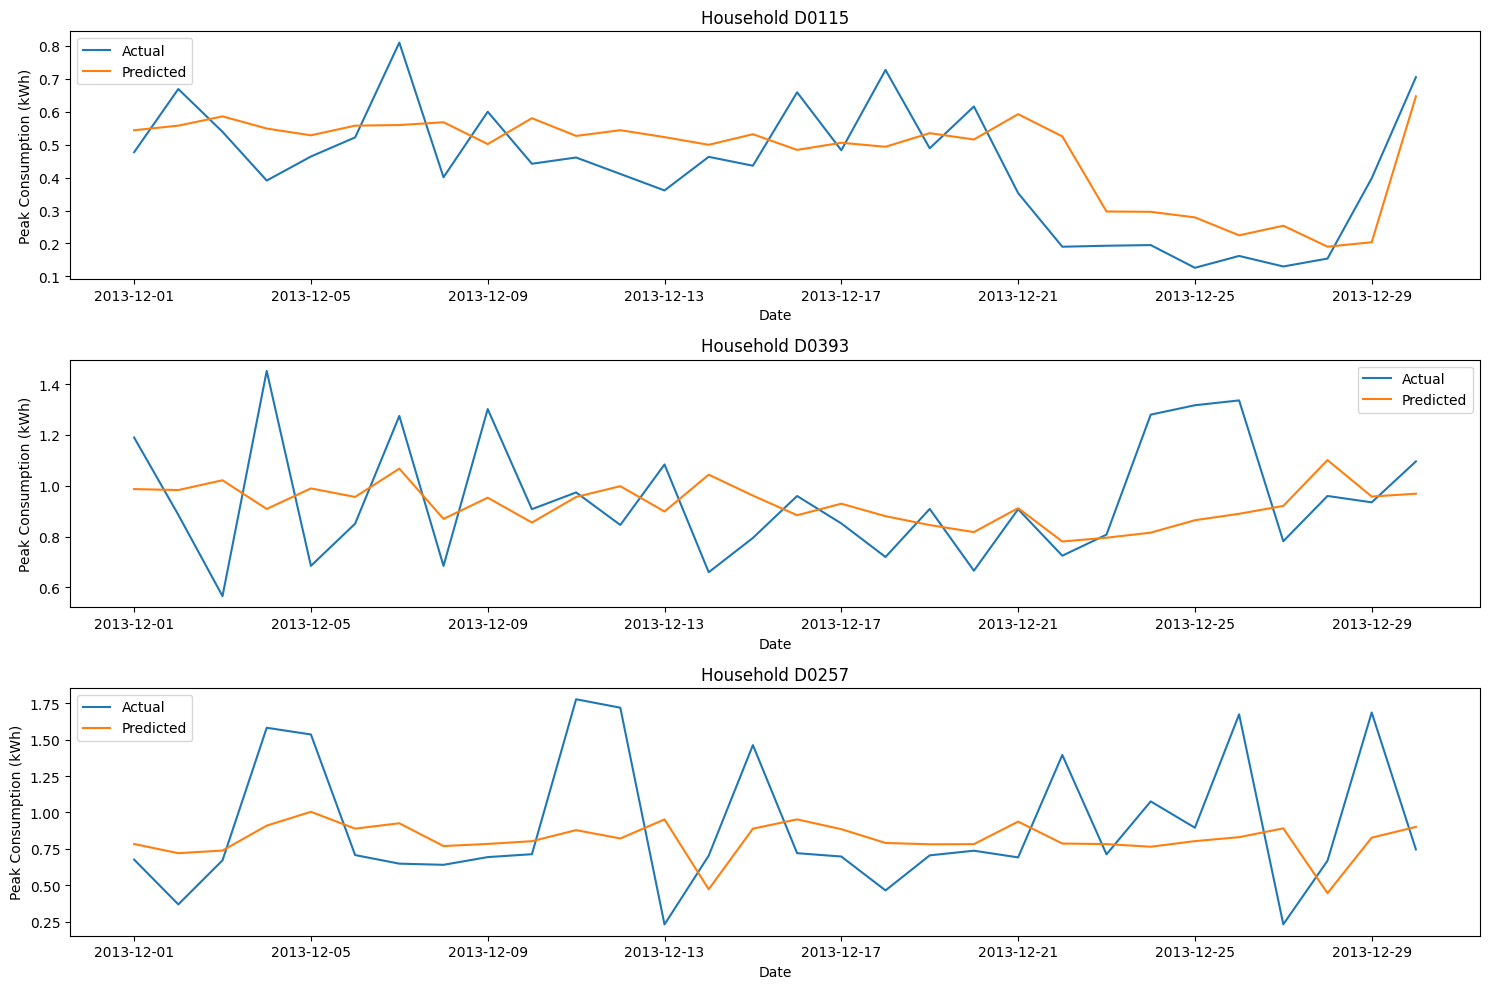

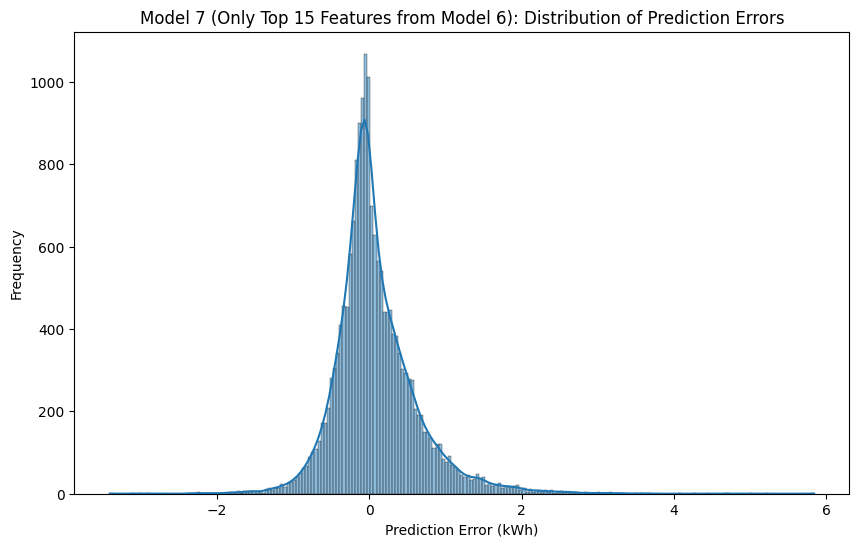


Summary Statistics for Model 7 (Only Top 15 Features from Model 6):
Mean Error: 0.0871
Median Error: -0.0073
Standard Deviation of Error: 0.5525
5th Percentile of Error: -0.6347
95th Percentile of Error: 1.0669

___________________________________________________________


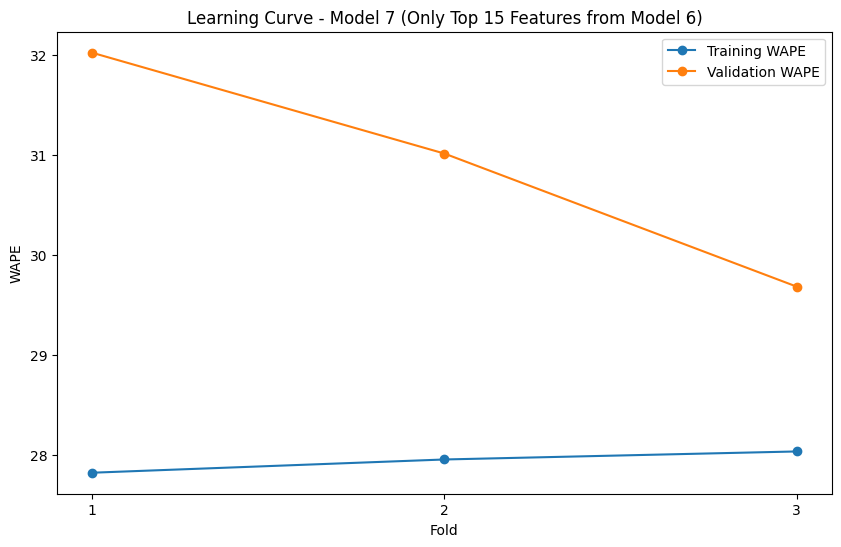

Training WAPE scores: [27.82229446083627, 27.954641859746545, 28.03495066396011]
Validation WAPE scores: [32.020986591811116, 31.01291416286273, 29.682873437028263]


In [13]:
# Plot test results for Model 7
plot_test_results("Model 7 (Only Top 15 Features from Model 6)", test_predictions_7, y_test_7, test_household_ids_7, test_dates_7)

# Plot learning curve for Model 7
plot_learning_curve(model_7, df, model_7_features, 'cbrt_consumption_peak_next_day', folds, "Model 7 (Only Top 15 Features from Model 6)")